In [1]:
import numpy as np
import pulser
from pprint import pprint
import matplotlib.pyplot as plt

from scipy.linalg import expm

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
# Parameters in rad/µs and ns
Omega = 1 *2*np.pi
delta = 0.7*2*np.pi
U = 138e5

C6 = Chadoq2.interaction_coeff
print(Chadoq2.interaction_coeff)

d = Chadoq2.rydberg_blockade_radius(Omega)
print(d)
print((C6/Omega)**(1/6))

# print((U/Omega)**(1/6))
# Omega = Omega/U*C6
# delta = delta/U*C6
# d = Chadoq2.rydberg_blockade_radius(Omega)
# print(d)

5420158.53
9.756753962298905
9.756753962298905


11.401181768748398


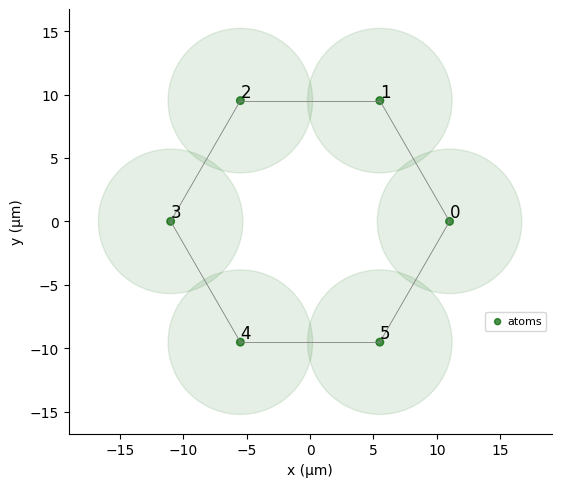

In [3]:
n = 6
print((U/Omega)**(1/6))
w = np.exp(1j*2*np.pi/(n))

rNN = 11
G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]

Rij1 = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]

#H1 = H.copy()
#for i in range(n):
#    for j in range(i):
#        H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [4]:
#G2 = [(0,rNN/2),(0,-rNN/2),(rNN,rNN/2),(rNN,-rNN/2),(2*rNN,rNN/2),(2*rNN,-rNN/2)]

##G2 = [(rNN/1.9*np.cos(2*np.pi*j/3),rNN/1.9*np.sin(2*np.pi*j/3)) for j in range(3) ] + [(2*rNN-rNN/1.9*np.cos(2*np.pi*j/3),rNN/1.9*np.sin(2*np.pi*j/3)) for j in range(3) ]

##G2 = [(rNN*2*np.cos(2*np.pi*j/6),rNN*2*np.sin(2*np.pi*j/6)) for j in range(6) ]

#B2 = [0,1,2,3,4,5]
#C2 = [0,1,2,3,4,5]

#qubits2 = dict(enumerate(G2))
#reg2 = Register(qubits2)

#reg2.draw(blockade_radius=rNN, draw_half_radius=True, draw_graph=True)

In [5]:
M = 100
T = 1000*np.linspace(0.05,2.5,M)
t_pulses = [Pulse.ConstantPulse(int(t),Omega,delta,0) for t in T]


/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 2425 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 2428 ns.
  self._add(pulse, channel, protocol)


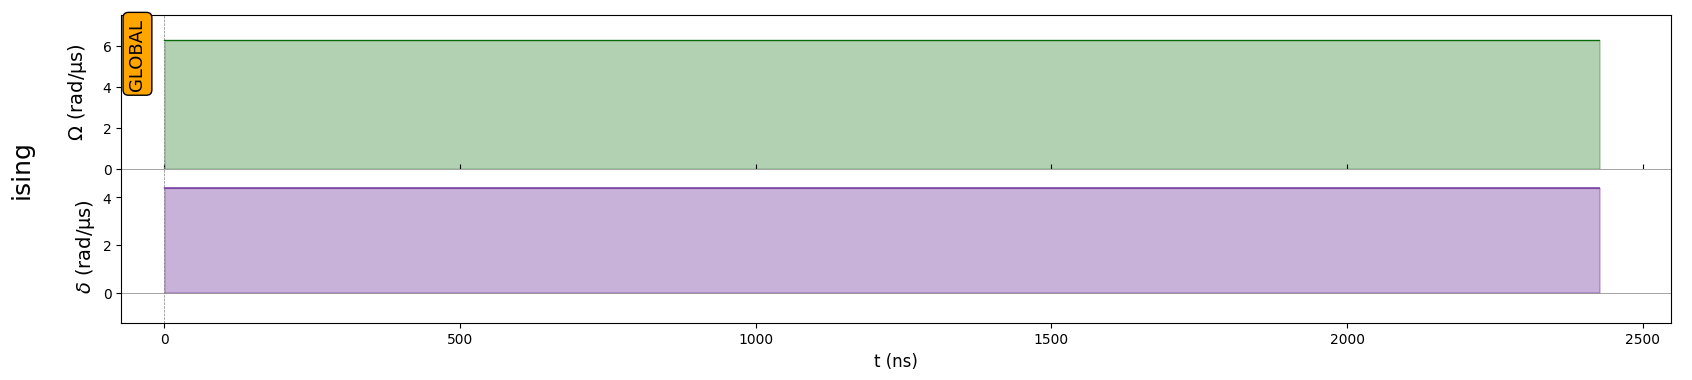

In [6]:
mydevice = pulser.devices.VirtualDevice('Mydevice', dimensions=2, rydberg_level=70)
seq = Sequence(reg1, mydevice)

seq = Sequence(reg1, Chadoq2)

seq.declare_channel("ising", "rydberg_global")
#seq.available_channels

seq.add(t_pulses[-4],"ising")
#seq.measure(basis="ground-rydberg")
seq.draw()

In [7]:
seq.declared_channels

{'ising': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

In [8]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)

# results = sim.run(progress_bar=True)
# print(results.sample_final_state(N_samples=1000))

In [9]:
N_samples = 250
n_qubits = 6

# count_dict = results.sample_final_state(N_samples=N_samples)


ncount = np.zeros(M)



for i,t in enumerate(T):

    t_pulse = Pulse.ConstantPulse(int(t),Omega*2,delta,0)
    seq = Sequence(reg1, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(t_pulse,"ising")

    sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    results = sim.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=N_samples)
    
    for el,count in count_dict.items():
        for j,qubitval in enumerate(el[::-1]):
            #if j in B1 and qubitval=="1":
            #    n1_B[i] += count / N_samples / len(B1)
            #elif j in C1 and qubitval=="1":
            #    n1_C[i] += count / N_samples / len(C1)
            if qubitval=="1":
                ncount += count / N_samples / 6

    #seq = Sequence(reg2, Chadoq2)
    #seq.declare_channel("ising", "rydberg_global")
    #seq.add(t_pulse,"ising")
    
    #sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    #results = sim.run(progress_bar=False)
    #count_dict = results.sample_final_state(N_samples=N_samples)
    
    #for el,count in count_dict.items():
    #    for j,qubitval in enumerate(el[::-1]):
    #        if j in B2 and qubitval=="1":
    #            n2_B[i] += count / N_samples / len(B2)
    #        elif j in C2 and qubitval=="1":
    #            n2_C[i] += count / N_samples / len(C2)



/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 50 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 52 ns.
  self._add(pulse, channel, protocol)
/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 74 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 76 ns.
  self._add(pulse, channel, protocol)
/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 99 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 100 ns.
  self._add(pulse, channel, protocol)
/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 173 ns is not a multiple of the cha

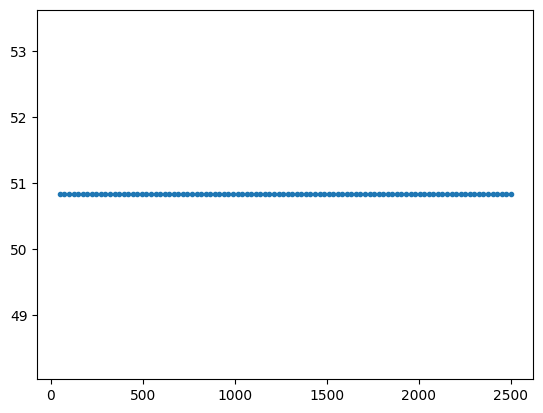

In [10]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))

plt.plot(T,ncount,'.-',label="n1_B")

In [11]:
#def Kron(*arr):
#    K = arr[0]
#    for i in range(1,len(arr)):
#        K = np.kron(K,arr[i])
#    return K

#I = np.eye(2)
#Z = np.array([[1,0],[0,-1]])
#X = np.array([[0,1],[1,0]])

#Xi = np.concatenate(([Kron(X,I,I,I,I,I)],[Kron(*([I]*i+[X]+[I]*(6-i-1))) for i in range(1,5)],[Kron(I,I,I,I,I,X)]))
#Zi = np.concatenate(([Kron(Z,I,I,I,I,I)],[Kron(*([I]*i+[Z]+[I]*(6-i-1))) for i in range(1,5)],[Kron(I,I,I,I,I,Z)]))
#Ni = (np.eye(2**6)+Zi)/2


#rNN = 5.3
#Omega = 1   * 2*np.pi
#delta = 0.7 * 2*np.pi

#H = Omega/2*np.sum(Xi, axis=0) - delta*np.sum(Ni, axis=0)
##G1 = [(0,rNN/2),(0,-rNN/2),(rNN*np.sqrt(3)/2,0),(rNN*np.sqrt(3)/2+rNN,0),(rNN*np.sqrt(3)+rNN,rNN/2),(rNN*np.sqrt(3)+rNN,-rNN/2)]
##G2 = [(0,rNN/2),(0,-rNN/2),(rNN,rNN/2),(rNN,-rNN/2),(2*rNN,rNN/2),(2*rNN,-rNN/2)]
#B = [0,1,2,3,4,5]
#C = [0,1,2,3,4,5]
## U = 138*1e5
## U = 5420158.53
## U = 1.38e6

#Rij1 = np.zeros((6,6))
#for i in range(6):
#    for j in range(i):
#        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
#        Rij1[j,i] = Rij1[i,j]
        
#H1 = H.copy()
#for i in range(6):
#    for j in range(i):
#        H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2
        
#Rij2 = np.zeros((6,6))
#for i in range(6):
#    for j in range(i):
#        Rij2[i,j] = np.linalg.norm(np.array(G2[i])-np.array(G2[j]))
#        Rij2[j,i] = Rij2[i,j]
        
#H2 = H.copy()
#for i in range(6):
#    for j in range(i):
#        H2 += U/Rij2[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2

In [12]:
#plt.imshow(H)
#plt.colorbar()

In [13]:
#v = Kron(*[np.array([0,1])]*6)

#def Obs(v,A):
#    return (np.sum( [v.transpose().conj()@Ni[i]@v for i in A] )).real/len(A)

In [14]:
# T = np.linspace(0.05,2.5,M)

#O1_B = np.zeros((M))
#O1_C = np.zeros((M))
#O2_B = np.zeros((M))
#O2_C = np.zeros((M))
#for i,t in enumerate(T):
#    vt = expm(-1j*t*H1/1000)@v
#    O1_B[i] = Obs(vt,B)
#    O1_C[i] = Obs(vt,C)
    
#    vt = expm(-1j*t*H2/1000)@v
#    O2_B[i] = Obs(vt,B)
#    O2_C[i] = Obs(vt,C)

In [15]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))

#ax1.plot(T,n1_B,'.-',label="n1_B")
#ax1.plot(T,n2_B,'.-',label="n2_B")
##ax1.plot(T,O1_B,label="n1_B_theory")
##ax1.plot(T,O2_B,label="n2_B_theory")
#plt.ylim([0,0.5])

#ax2.plot(T,n1_C,'.-',label="n1_C")
#ax2.plot(T,n2_C,'.-',label="n2_C")
##ax2.plot(T,O1_C,label="n1_C_theory")
##ax2.plot(T,O2_C,label="n2_C_theory")
##ax2.ylim([0,0.5])

#ax1.legend()
#ax2.legend()

#plt.tight_layout()

#plt.show()

In [16]:
import matplotlib.pyplot as plt

points = [(  -0.180226841   ,   0.360945118   ,  -1.120304970 ),
       (-0.180226841    ,  1.559292118   ,  -0.407860970),
       (-0.180226841  ,    1.503191118   ,   0.986935030),
       (-0.180226841  ,    0.360945118   ,   1.29018350),
       (-0.180226841  ,   -0.781300882   ,   0.986935030),
       (-0.180226841  ,   -0.837401882   ,  -0.407860970),
       (-0.180226841   ,   0.360945118   ,  -2.206546970),
       (-0.180226841   ,   2.517950118   ,  -0.917077970),
       (-0.180226841   ,   2.421289118   ,   1.572099030),
       (-0.180226841   ,  -1.699398882  ,    1.572099030),
       (-0.180226841  ,   -1.796059882 ,    -0.917077970)]

import numpy as np
points = np.array(points)

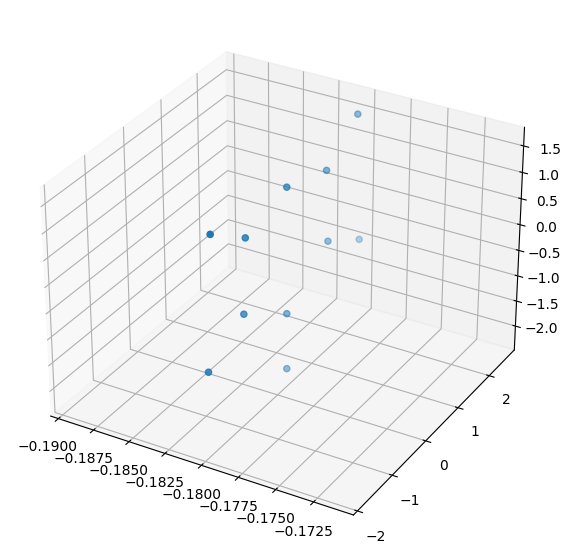

In [17]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(points[:,0],points[:,1],points[:,2])

In [18]:
import numpy as np
from sklearn.decomposition import PCA

points = [(  -0.180226841   ,   0.360945118   ,  -1.120304970 ),
       (-0.180226841    ,  1.559292118   ,  -0.407860970),
       (-0.180226841  ,    1.503191118   ,   0.986935030),
       (-0.180226841  ,    0.360945118   ,   1.29018350),
       (-0.180226841  ,   -0.781300882   ,   0.986935030),
       (-0.180226841  ,   -0.837401882   ,  -0.407860970),
       (-0.180226841   ,   0.360945118   ,  -2.206546970),
       (-0.180226841   ,   2.517950118   ,  -0.917077970),
       (-0.180226841   ,   2.421289118   ,   1.572099030),
       (-0.180226841   ,  -1.699398882  ,    1.572099030),
       (-0.180226841  ,   -1.796059882 ,    -0.917077970)]

points = np.array(points)

pca = PCA(n_components=2)
pca.fit(points)
print("normal vector: ",np.cross(pca.components_[0],pca.components_[1]))

normal vector:  [-1.00000000e+00 -2.19722562e-33  0.00000000e+00]


In [19]:
pointspca = pca.transform(points)

In [20]:
np.cross(pca.components_[0],pca.components_[1])

array([-1.00000000e+00, -2.19722562e-33,  0.00000000e+00])

In [21]:
print(pca.components_)
print()
print(pca.explained_variance_ratio_)

[[-2.19722562e-33  1.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.00000000e+00]]

[0.58258787 0.41741213]
